# Project 2

- Leonardo Meireles Murtha Oliveira : 4182085
- Vitor Augusto Oliveira: NUMSUP

## 1.

For	the	following	networks:  


a)	E-road	network	(http://konect.cc/networks/subelj_euroroad),  
b)	Hamsterster	friendships	(http://konect.uni-koblenz.de/networks/petsterfriendships-hamster).  	
c)	C.	elegans	neural	network	(http://wwwpersonal.umich.edu/~mejn/netdata/celegansneural.zip)  
d)	US	airport	network (http://toreopsahl.com/datasets/#usairports)  

<hr>

Construct	a	correlation	matrix	between	the	centrality	measures:	(i)	degree,	(ii)	kcore,	(iii)	closeness	centrality,	(iv)	betweenness	centrality,	(v)	eigenvector	
centrality,	(vi)	pagerank,	(vi)	random	walk	accessibility,	(v)	communicability	
centrality.  

Discuss	the	highest	correlations	and	interpret	the	results.

In [1]:
# Importing essential libraries for the exercises
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import multiprocessing as mp
import seaborn as sns
sns.set()
import matplotlib
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')


In [2]:
def connected_component_subgraphs(G):
    return [G.subgraph(c).copy() for c in nx.connected_components(G)]

In [3]:
def process_net(G, to_undirected=False):
    """
    Does some processing on the network:
        - If set G is transformed in an undirected graph
        - G labels become integers so it's easier to operate
        - Then we only get the biggest connected subgraph so we can calculate some measures
    """
    G = nx.Graph(G)
    G = nx.to_undirected(G)
    G = nx.convert_node_labels_to_integers(G, first_label=0)
    
    G = max(connected_component_subgraphs(G), key=len)
    G.remove_edges_from(nx.selfloop_edges(G))

    return G

In [4]:
def prob_distribution(G):
    # let networkx return the adjacency matrix A
    A = np.array(nx.adj_matrix(G).todense(), dtype=np.float64)
    dk = dict(G.degree())
    vk = list(dk.values())
    P = np.zeros(A.shape)

    # Creating the probability distribution matrix
    for i in range(len(A)):
        P[i, :] = A[i, :]/vk[i]

    return P

In [5]:
from scipy.linalg import expm


def random_walk_accessibility(G):
    N = len(G.nodes())
    
    # Prob distrib matrix P
    P = prob_distribution(G)
    
    # Compute the matrix exponential using Pade approximation.
    # W(i,j) provides the mean number of visits that node j receives when starting from node i
    # And follows the ARW
    W = expm(P)
    
    # P_ARW = W/e
    P_ARW = W / np.exp(1)
    
    # computing alpha(i) = shannon(P, i, j=1...N)
    arw = np.zeros(N, dtype=np.float)
    
    for i in range(0, N):
        arw_i = 0    
        for j in range(0, N):
            if(P_ARW[i, j] > 0):
                arw_i = arw_i + P_ARW[i, j]*np.log(P_ARW[i, j])
                
        # Shannon Entropy
        arw[i] = np.exp(-arw_i)
    
    return arw

In [6]:
def centrality_measures(G):
    c_measures = {'Degree': list(nx.degree_centrality(G).values()), 
                  'K-Core': list(nx.core_number(G).values()), 
                  'Closeness': list(nx.closeness_centrality(G).values()),
                  'Betweness': list(nx.betweenness_centrality(G).values()),
                  'Eigenvector': list(nx.eigenvector_centrality_numpy(G).values()),
                  # Google's alpha
                  'PageRank': list(nx.pagerank(G, alpha=0.85).values()),
                  'Random Walk Accessibility': random_walk_accessibility(G)}
                  #'Communicabiliity': list(nx.communicability_betweenness_centrality(Gb).values())}
    
    return c_measures

In [7]:
def histogram_plot(x, title):
    plt.figure(figsize=(8, 8))
    plt.title(title)
    sns.distplot(x, rug=True, rug_kws={"color": "g"},
                   kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                   hist_kws={"histtype": "step", "linewidth": 3,
                             "alpha": 1, "color": "g"})

In [8]:
# Reading the nets
eroad_net = nx.read_edgelist(path='nets/subelj_euroroad/out.subelj_euroroad_euroroad', comments='%')
hamster_net = nx.read_edgelist(path='nets/out.petster-friendships-hamster-uniq', comments='%')
celegan_net = nx.read_gml(path='nets/celegansneural/celegansneural.gml',)
airport_net = nx.read_weighted_edgelist(path='nets/USairport500.dl.txt', comments='%') 

nets = {'E-road' : process_net(eroad_net), 
        'Hamster' : process_net(hamster_net), 
        'Celegan' : process_net(celegan_net),
        'Airport' : process_net(airport_net)}

Computing the centrality measures for each network

In [9]:
# Using dict so later we will be able to use dataframes to compute correlations
net_c_measures = {name: centrality_measures(net) for name, net in nets.items()}

In [10]:
def correlation_plot(net_name, c_measures):
    # Compute the correlation matrix
    df = pd.DataFrame(c_measures)
    corr = df.corr()
    plt.figure(figsize=(8, 8))
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    with sns.axes_style("white"):ax = sns.heatmap(corr, mask=mask, vmax=1, square=True)
    plt.title('Correlation between centrality measures for %s network' % net_name)
    plt.show(True)

E-road network centrality measures correlation

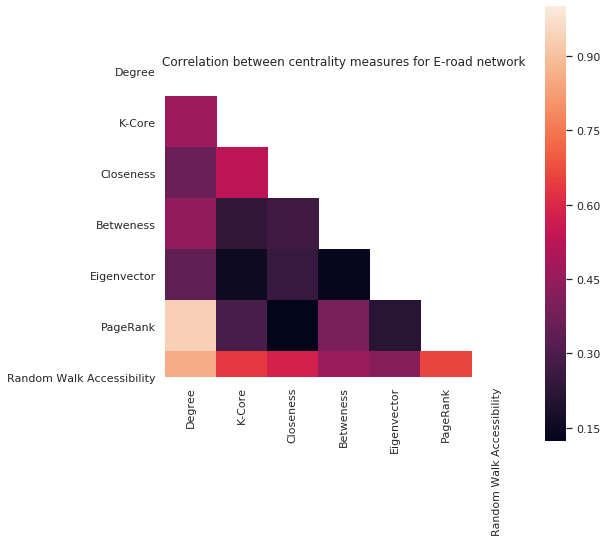

In [11]:
correlation_plot('E-road', net_c_measures['E-road'])

Hamster centrality measures correlation

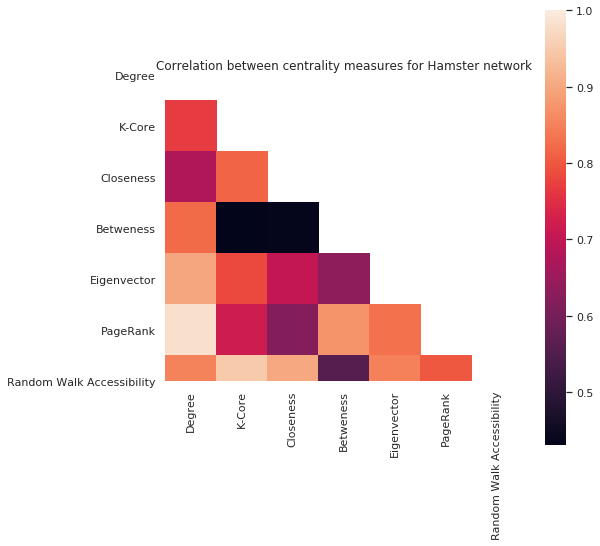

In [12]:
correlation_plot('Hamster', net_c_measures['Hamster'])

Celegan centrality measures correlation

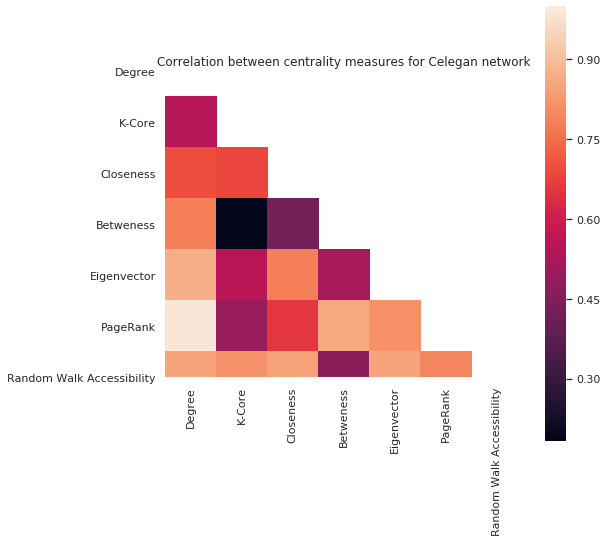

In [13]:
correlation_plot('Celegan', net_c_measures['Celegan'])

US Airport centrality measures correlation

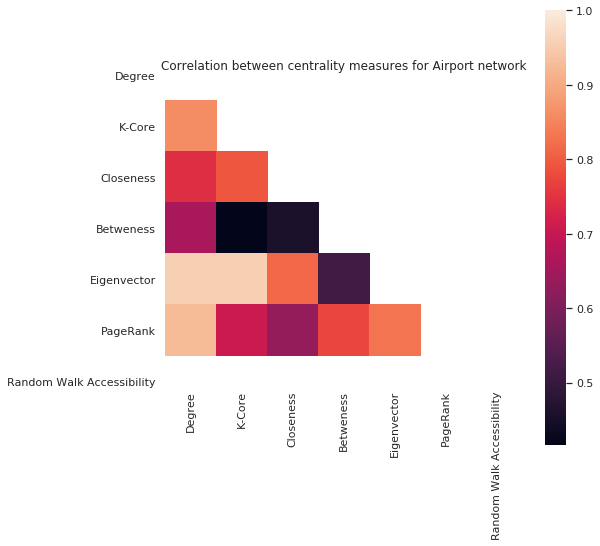

In [14]:
correlation_plot('Airport', net_c_measures['Airport'])

## 2.

Choose	four	dataset	of	cities	(from	OSMX	or	any	other	dataset) and	compare	 the	cities	in	terms	of	the	centrality	measures.	
That	is,	construct	the	histogram	of:   
(i)	degree,	  
(ii) closeness centrality   
(iii) betweenness	centrality.	  
Discuss which	city	is	easier	to	navigate	in	terms	of	these	distributions.

In [15]:
import osmnx as ox

cities = ['Paris, France', 'Berlin, Germany',
          'London, London', 'São Paulo, Brazil']

net_cities = {city: process_net(ox.graph_from_address(
    city, distance=1000, network_type='drive')) for city in cities}

In [16]:
city_measures = {name: centrality_measures(net) for name, net in net_cities.items()}

In [17]:
import seaborn as sns

colors = sns.color_palette("Paired")

def histogram_centrality_plot(city, measures):
    plt.figure(figsize=(7, 30))
    
    n = len(measures)
    
    i = 1
    for measure, values in measures.items():
        fig = plt.subplot(n, 1, i)
        plt.xlabel('P(%s)' % measure, fontsize=14)
        plt.ylabel('P(%s)' % measure, fontsize=14)
        # , rotation='vertical',x=-0.6,y=0.1)
        plt.title("%s %s centrality" % (city, measure), fontsize=14)
        plt.grid(True)
        # Plotting the distribution
        sns.distplot(values, color=colors[i])
        i += 1
        
    plt.tight_layout()
    plt.grid(True)
    plt.show(True)

Paris, France histogram's

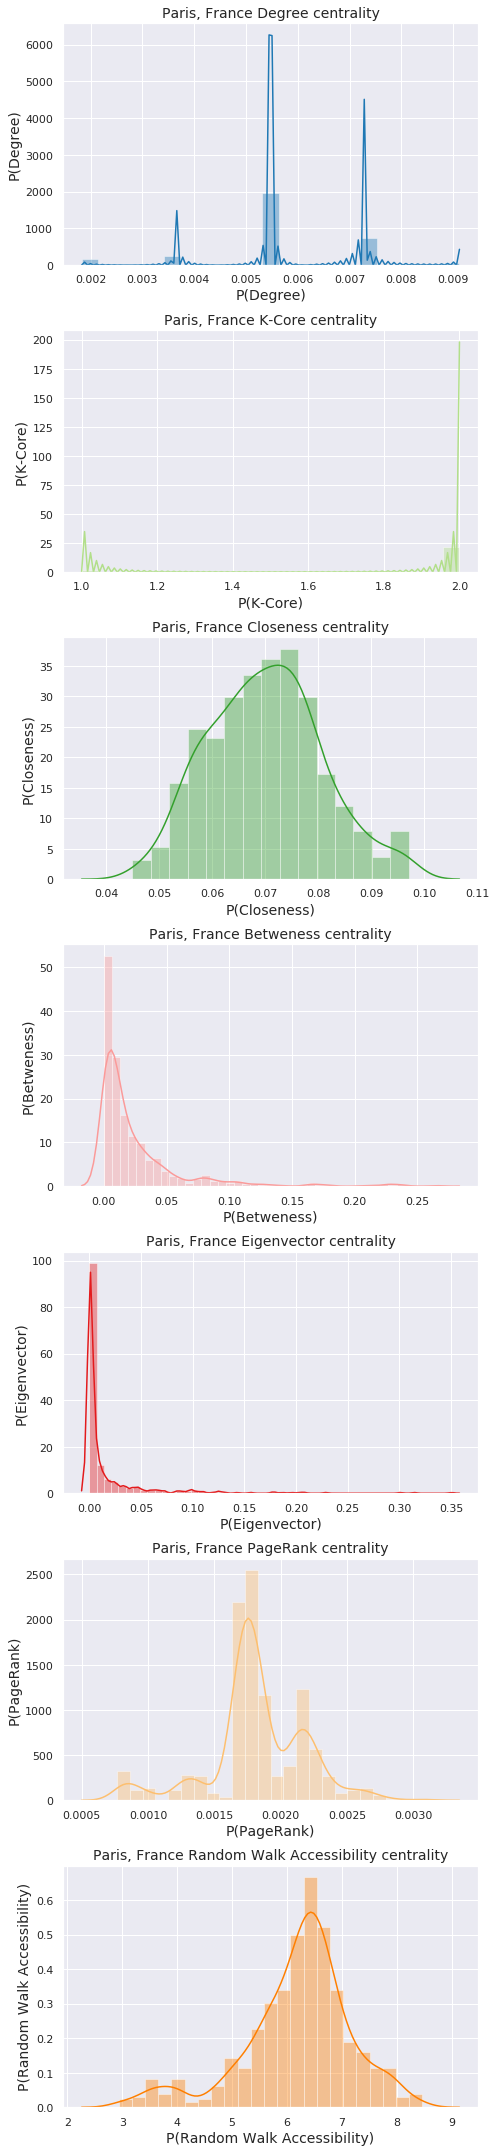

In [18]:
histogram_centrality_plot('Paris, France', city_measures['Paris, France'])

Berlin, Germany histogram's

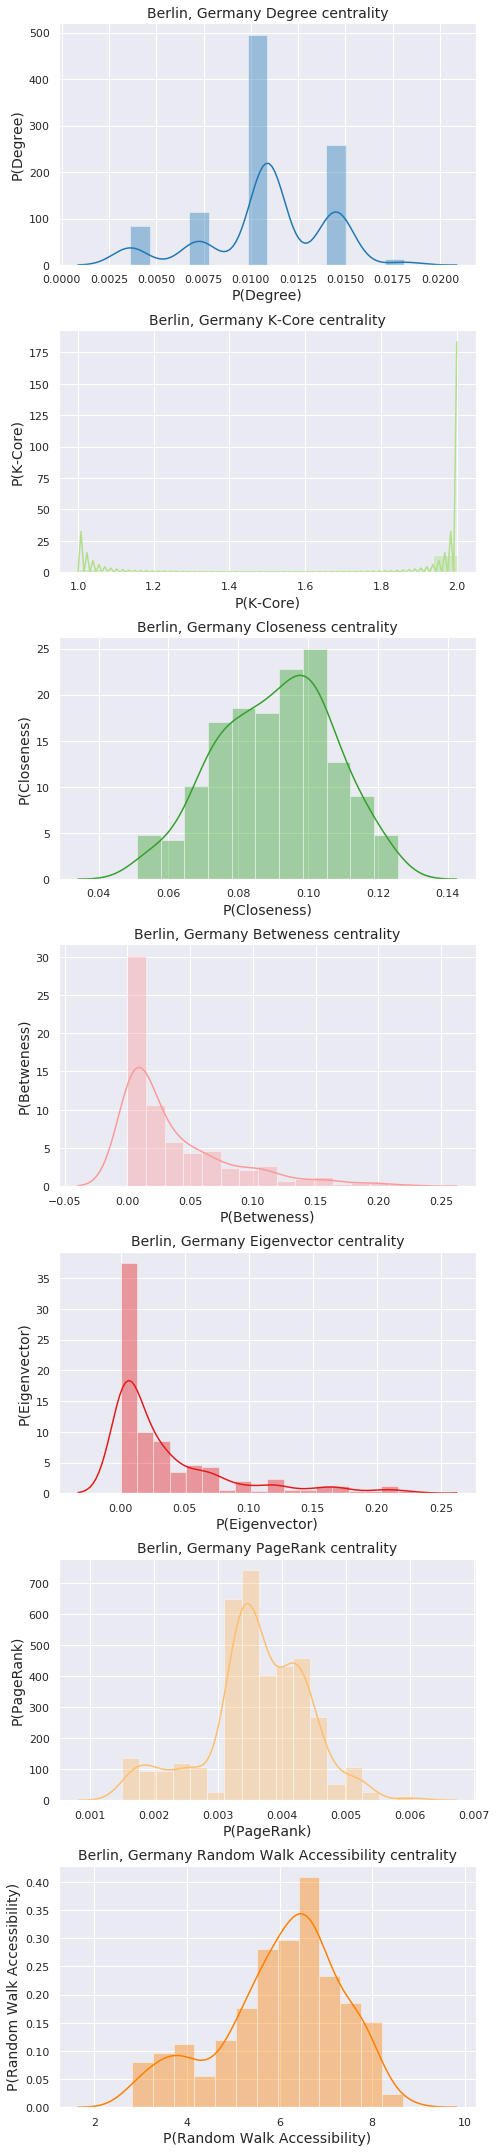

In [19]:
histogram_centrality_plot('Berlin, Germany', city_measures['Berlin, Germany'])

London, UK histogram's

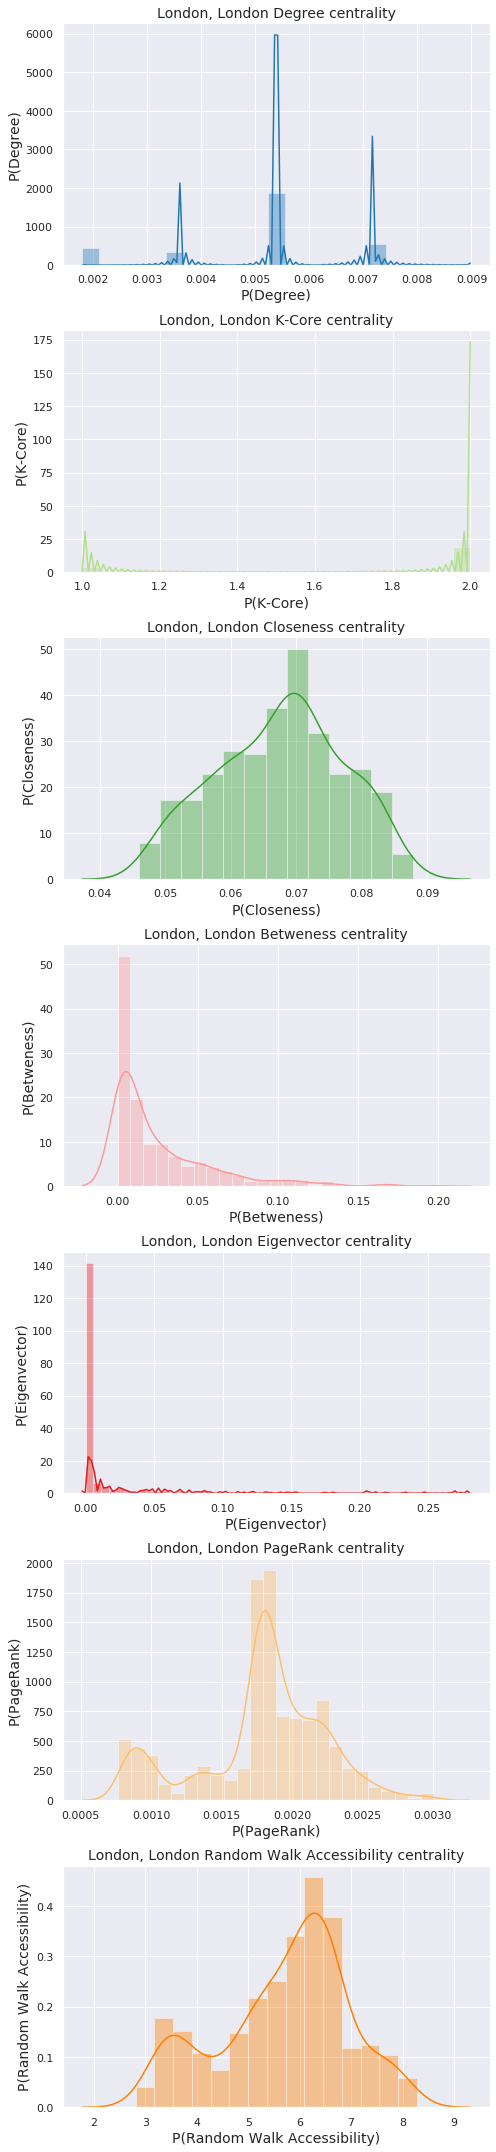

In [20]:
histogram_centrality_plot('London, London', city_measures['London, London'])

Sao Paulo, Brazil histogram's

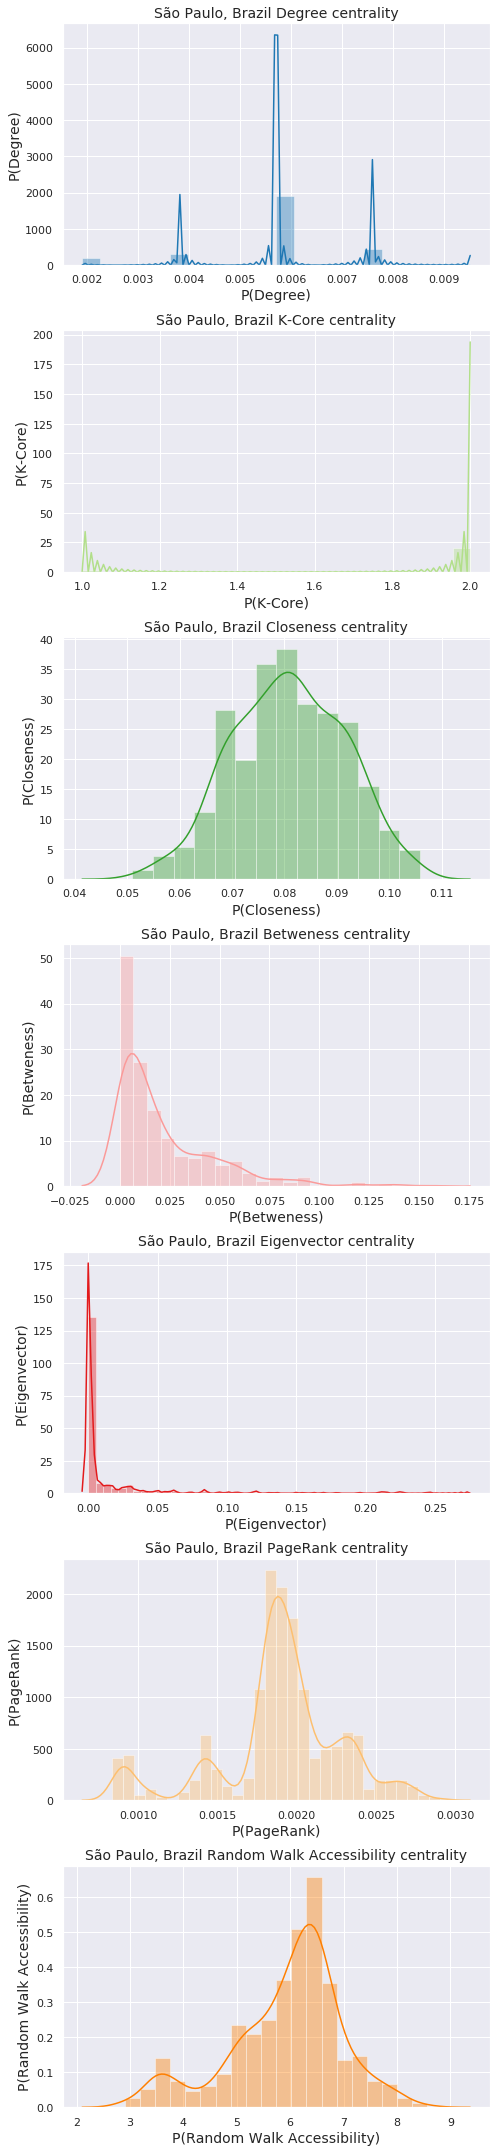

In [21]:
histogram_centrality_plot('São Paulo, Brazil', city_measures['São Paulo, Brazil'])

## 3.

In [22]:
# Reading the nets
human_proteins_net = nx.read_edgelist(
    path='nets/download.tsv.maayan-vidal/maayan-vidal/out.maayan-vidal', comments='%')
power_net = nx.read_gml(path='nets/power/power.gml', label='id')
elegan_protein_07_net = nx.read_edgelist(path='nets/wi2007.txt',)
elegan_protein_04_net = nx.read_edgelist(path='nets/wi2004.txt',)
r_dependecies_net = nx.read_edgelist(path='nets/dependencies.csv', delimiter=',')

nets = {'Human Proteins': process_net(human_proteins_net), 
        'Power Grid': process_net(power_net), 
        'Elegans Protein 2007': process_net(elegan_protein_07_net),
        'Elegans Protein 2004': process_net(elegan_protein_04_net),
        'R Dependencies': process_net(r_dependecies_net)}

Computing the centrality measures for each network

In [23]:
# Using dict so later we will be able to use dataframes to compute correlations
net_c_measures = {name: centrality_measures(net) for name, net in nets.items()}

Plotting the network centrality measures histograms

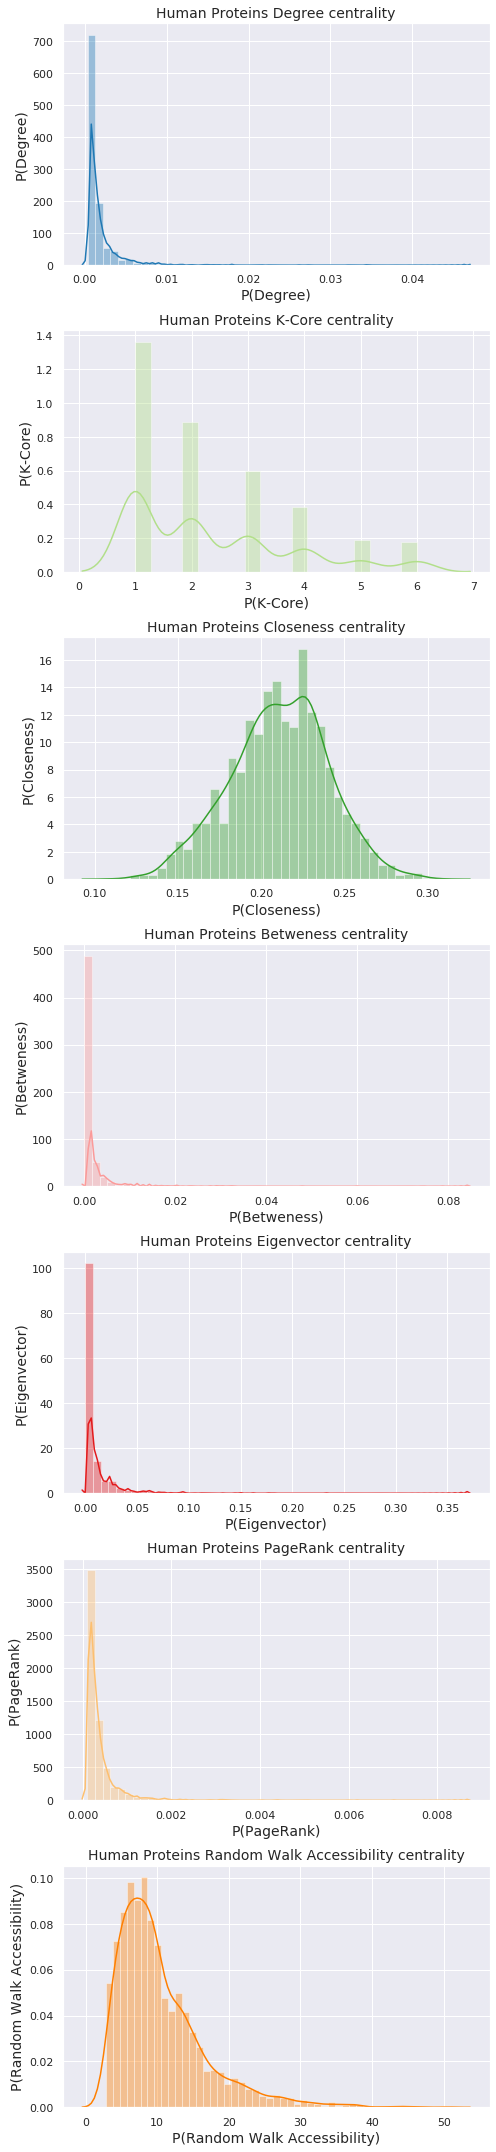

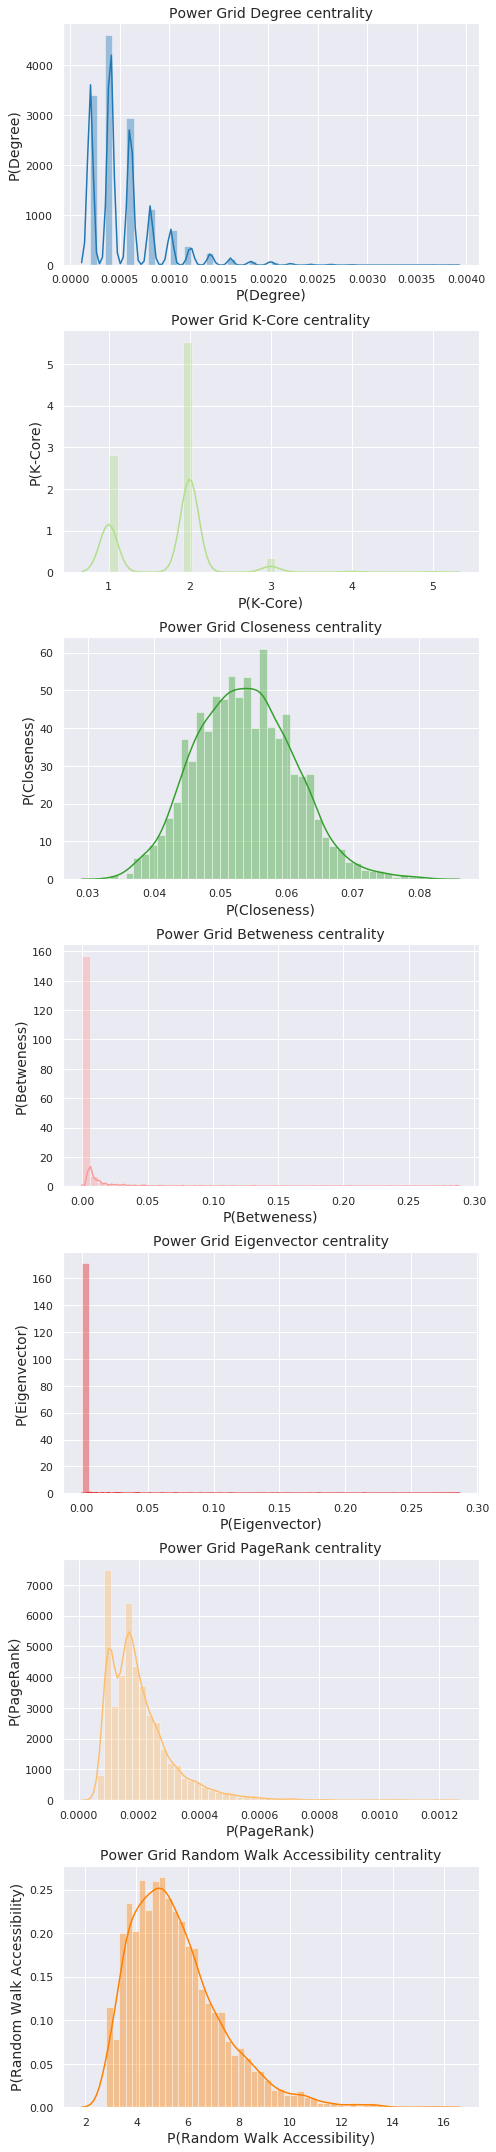

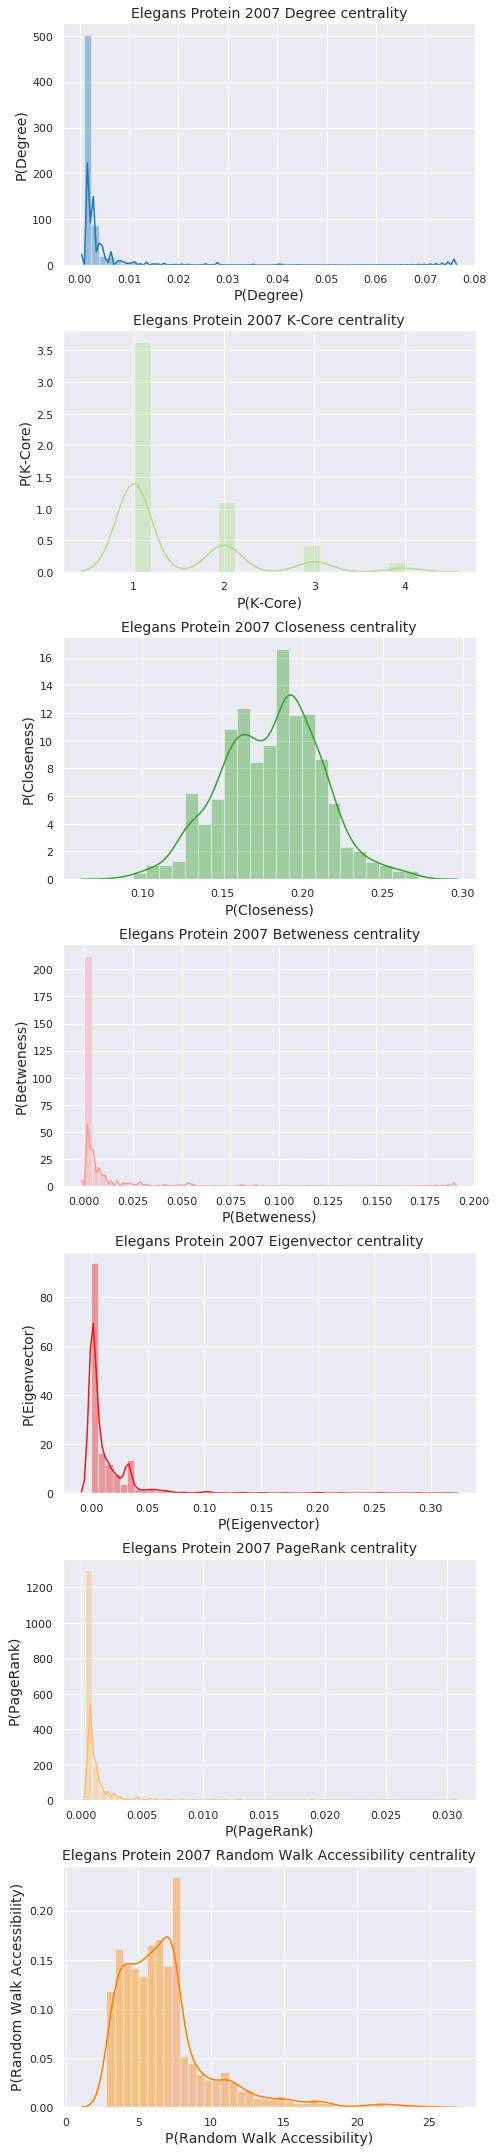

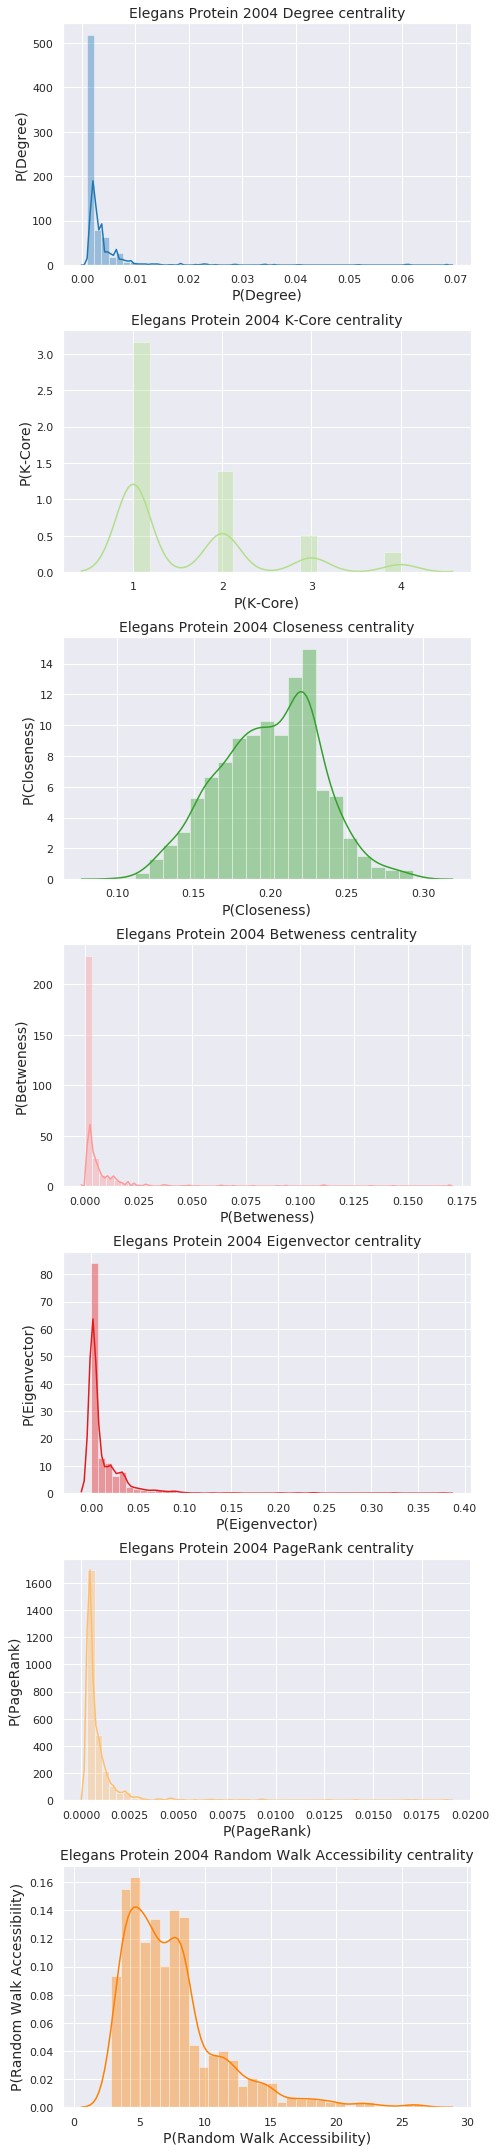

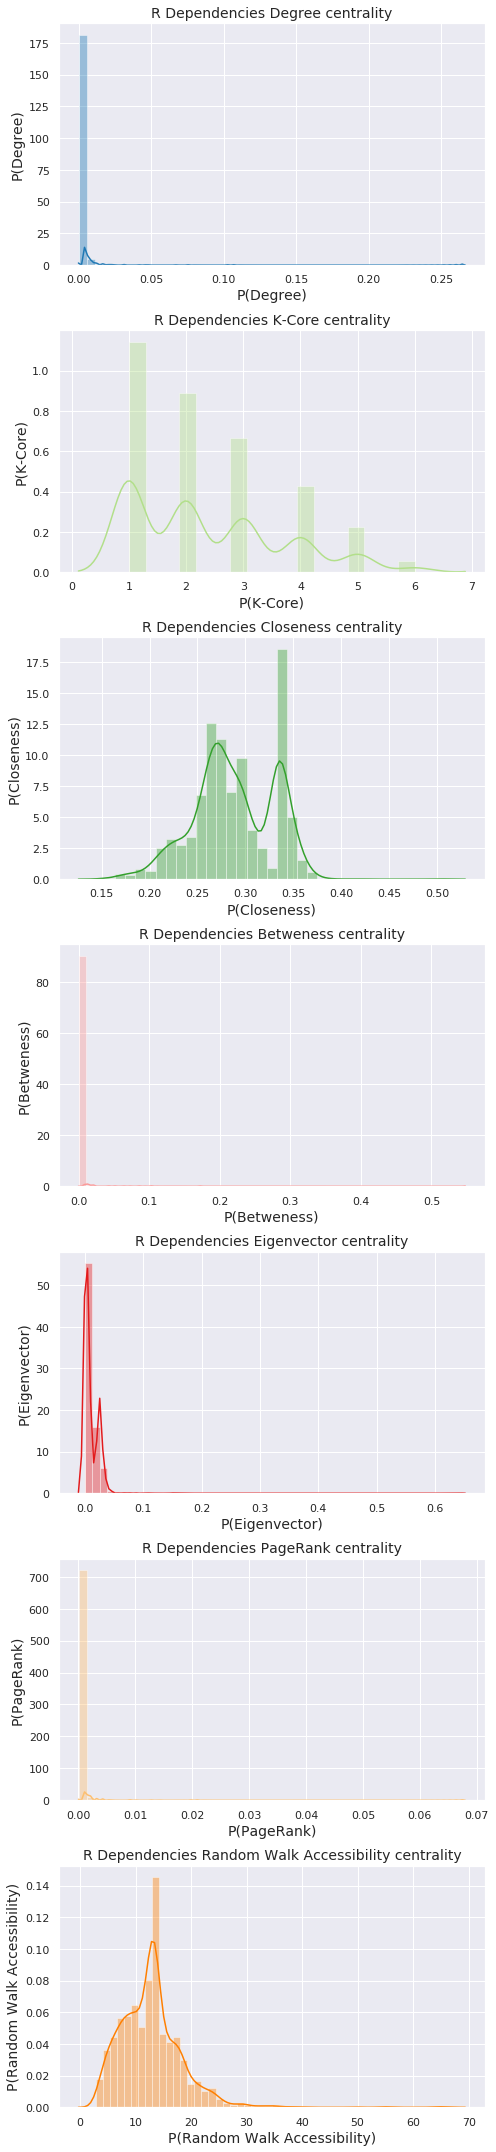

In [24]:
for name, measures in net_c_measures.items():
    histogram_centrality_plot(name, measures)

## 4.

In [25]:
from numpy import mean, std
from scipy.stats import moment, entropy


def run_stats(net, measures):
    stats = []
    
    stats.append(net)
    for measure in measures.values():
        stats.append(mean(measure))
        stats.append(std(measure))
        stats.append(moment(measure, moment=2))
        shannon = entropy(measure)
        shannon = shannon if (shannon != np.inf and shannon != -np.inf and -float('inf')) else 0
        stats.append(shannon)

    return stats

def measure_descriptive_stats(c_measures):
    # net kcore_mean kcore_std ...... pagerank_mean
    stats = {'net': []}

    keys = list(c_measures.values())[0].keys()
    stats.update({'%s_%s' % ((key.lower()).replace(' ', '_'), stat): [] for key in keys for stat in [
                 'mean', 'std', 'second_moment', 'shannon']})

    for net, measures in c_measures.items():
        measures_stats = run_stats(net, measures)
        stat_keys = list(stats.keys())
        stat_vals = list(stats.values())
        
        for stat, stat_list, m_stat in zip(stat_keys, stat_vals, measures_stats):
            stat_list.append(m_stat)
    
    
    df = pd.DataFrame.from_dict(stats)
    
    return df

The descriptive statistics for each network in a DataFrame

In [26]:
df = measure_descriptive_stats(net_c_measures)
df.head(5)

net  degree_mean  degree_std  degree_second_moment  \
0        Human Proteins     0.001552    0.002528          6.391470e-06   
1            Power Grid     0.000540    0.000363          1.314829e-07   
2  Elegans Protein 2007     0.002446    0.004521          2.044285e-05   
3  Elegans Protein 2004     0.002729    0.005046          2.546608e-05   
4        R Dependencies     0.001817    0.006960          4.844228e-05   

   degree_shannon  k-core_mean  k-core_std  k-core_second_moment  \
0        7.324674     2.356091    1.450602              2.104245   
1        8.320819     1.735074    0.576159              0.331959   
2        6.360616     1.459386    0.768967              0.591311   
3        6.344783     1.604244    0.857580              0.735443   
4        6.826711     2.372293    1.319720              1.741660   

   k-core_shannon  closeness_mean  ...  eigenvector_second_moment  \
0        7.755137        0.210941  ...                   0.000300   
1        8.449777        0.053679  ...                   0.000201   
2        6.894324        0.180538  ...                   0.000723   
3        6.863776        0.199402  ...                   0.000746   
4        7.652962        0.287902  ...                   0.000306   

   eigenvector_shannon  pagerank_mean  pagerank_std  pagerank_second_moment  \
0             6.802068       0.000359      0.000491            2.412312e-07   
1             0.000000       0.000202      0.000107            1.147117e-08   
2             5.966327       0.000903      0.001542            2.377718e-06   
3             5.920636       0.000923      0.001410            1.989448e-06   
4             7.112395       0.000409      0.001609            2.587877e-06   

   pagerank_shannon  random_walk_accessibility_mean  \
0          7.502704                       10.485232   
1          8.386265                        5.538008   
2          6.503274                        6.777836   
3          6.510622                        7.427450   
4          6.972289                       12.743441   

   random_walk_accessibility_std  random_walk_accessibility_second_moment  \
0                       6.149872                                37.820921   
1                       1.761827                                 3.104034   
2                       3.256353                                10.603832   
3                       3.725188                                13.877024   
4                       5.716627                                32.679820   

   random_walk_accessibility_shannon  
0                           7.783038  
1                           8.457823  
2                           6.912595  
3                           6.879089  
4                           7.710931  

[5 rows x 29 columns]

### Applying the Principal Component Analysis

In [27]:
# First we need to standardize the data because PCA algo does not do it
from sklearn.preprocessing import StandardScaler

#df.replace([np.inf, -np.inf], 0)
# Separating out the features
#df.replace(to_replace=np.inf, value=0)
x = df.iloc[:, 1:].values
# Separating out the target
y = df.iloc[:, 0].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

Applying the PCA on the standardized data.

In [28]:
from sklearn.decomposition import PCA

# 2D PCA
n_components = 2
pca = PCA(n_components=n_components)

principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=principalComponents, columns=[
                           'PC%d' % i for i in range(1, n_components + 1)])

In [29]:
# Appending the class labels i.e network names
finalDf = pd.concat([principalDf, df[['net']]], axis = 1)
finalDf.head()

PC1       PC2                   net
0  0.750357  4.203256        Human Proteins
1  7.394965 -1.369642            Power Grid
2 -2.430835 -3.404095  Elegans Protein 2007
3 -2.912657 -2.689897  Elegans Protein 2004
4 -2.801830  3.260378        R Dependencies

Visualizing the results of the PCA

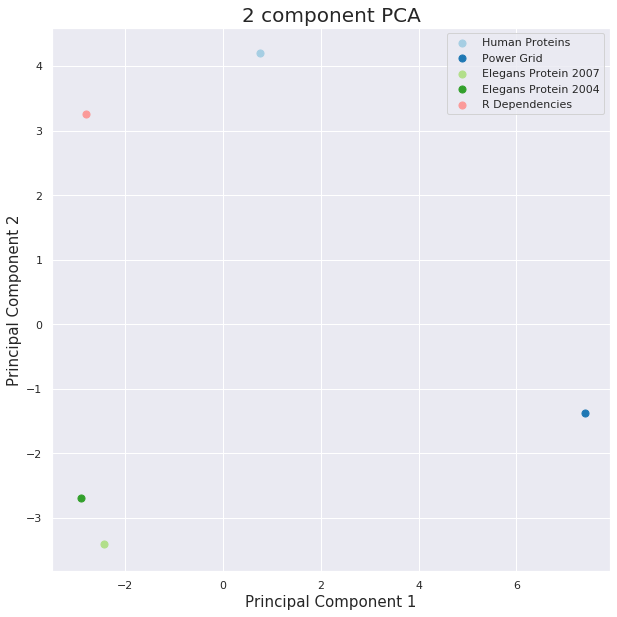

In [30]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

colors = sns.color_palette("Paired")[:len(x)]
for target, color in zip(finalDf['net'], colors):
    indicesToKeep = finalDf['net'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC2']
               , color = color
               , s = 50)
ax.legend(finalDf['net'])
ax.grid(True)

Analyzing the PCA results we can see that networks with the same domain i.e either biological or artificial are not just correlated by their domain. That is not all protein networks are close together in the PCA graph and that works for the artificial ones too.

## 5.

a)	E-road	network	(http://konect.cc/networks/subelj_euroroad),  
b)	C.	elegans	neural	network	 
(http://www-personal.umich.edu/~mejn/netdata/celegansneural.zip)  
c)	US	airport	network	(http://toreopsahl.com/datasets/#usairports)  
d)	Human	protein	network	(http://konect.cc/networks/maayan-vidal)  

Obtain	the	scatterplot	of	knn(k)	X	k	and	calculate	the	Pearson	correlation	coefficient	between	these	two	measures.	Compare	it	with	the	assortativity coefficient.  
Comment the	results.

In [31]:
def calc_knn(G):
    return np.array([avg for avg in nx.average_neighbor_degree(G).values()])

In [32]:
# Reading the nets
eroad_net = nx.read_edgelist(path='nets/subelj_euroroad/out.subelj_euroroad_euroroad', comments='%')
celegan_net = nx.read_gml(path='nets/celegansneural/celegansneural.gml',)
airport_net = nx.read_weighted_edgelist(path='nets/USairport500.dl.txt', comments='%') 
human_proteins_net = nx.read_edgelist(
    path='nets/download.tsv.maayan-vidal/maayan-vidal/out.maayan-vidal', comments='%')

nets = {'E-road' : process_net(eroad_net), 
        'Airport' : process_net(airport_net), 
        'Celegan' : process_net(celegan_net),
        'Human_Protein' : process_net(human_proteins_net)}

In [33]:
import scipy

def plot_knn_k(G, net):
    vk = list(dict(nx.degree(G)).values())
    knn = calc_knn(G)
    knnk = list()
    ks = list()
    
    for k in np.arange(np.min(vk), np.max(vk)):
        if(len(knn[vk == k]) > 0):
            av_knn = np.mean(knn[vk == k]) #average clustering among all the nodes with degree k
            knnk.append(av_knn)
            ks.append(k)
    
    plt.plot(ks, knnk, 'ro')
    plt.title("Average neighborhood connectivity vs degree of %s" % net)
    plt.ylabel("knn(k)")
    plt.xlabel("k")
    
    # determine best fit line
    par = np.polyfit(ks, knnk, 1, full=True)
    slope=par[0][0]
    intercept=par[0][1]
    xl = [min(ks), max(ks)]
    yl = [slope*xx + intercept  for xx in xl]
    plt.plot(xl, yl, '-b')
    plt.show(True)
    
    rho = scipy.stats.pearsonr(ks, knnk)[0]
    print('Pearson correlation coefficient of %s: %s' % (net, rho))

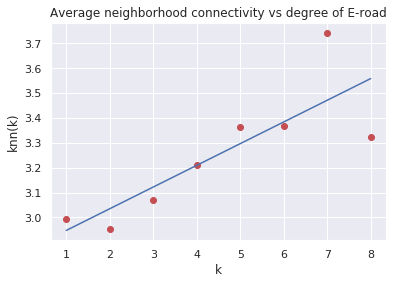

Pearson correlation coefficient of E-road: 0.8296047846722234


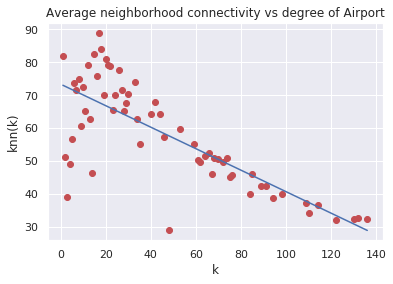

Pearson correlation coefficient of Airport: -0.7756491513624392


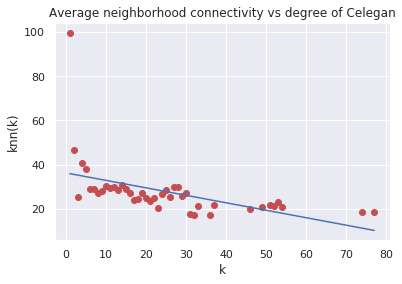

Pearson correlation coefficient of Celegan: -0.49478113193240253


Pearson correlation coefficient of Human_Protein: -0.7264791351157314


In [34]:
for net, graph in nets.items():
    plot_knn_k(graph, net)

Analyzing the results we can infer that the only assortative network(**knn(k) increases with k**) is the E-road network.

## 6.

In [35]:
# Generating the community structure
from networkx.generators.community import LFR_benchmark_graph
N = 128
tau1 = 4
tau2 = 1.7
mu = 0.04
k =16
minc = 32
maxc = 32
G = LFR_benchmark_graph(n = N, tau1 = tau1, tau2 = tau2, mu = mu, min_degree = 16, 
                        max_degree = k, min_community=minc, max_community = maxc, seed = 10)
pos=nx.spring_layout(G)
nx.draw(G, with_labels = False, nodecolor='r', edge_color='g', 
        node_size=50, font_size=16,  width=1,pos = pos)
plt.show(True)

In [36]:

def plot_communities(G, c, method):
    
    pos=nx.spring_layout(G)
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    plt.figure()
    plt.figure(figsize=(16, 10))
    
    count = 0
    plt.title('Communities found using %s' % method)
    
    norm = matplotlib.colors.Normalize(vmin=0, vmax=len(c))
        
    for cm in c:
        nx.draw_networkx(G.subgraph(cm), pos=pos, node_color=np.array(plt.cm.jet(norm(count))), with_labels = False, node_size=50)
        count = count + 1
    plt.show(True)

In [37]:
## drawing
def plot_louvain(G, partition, mutual=True):
    plt.figure(figsize=(16, 10))
    
    pos = nx.spectral_layout(G)
    if mutual:
        labels_true = {frozenset(G.nodes[v]['community']) for v in G}
        labels_true = [list(c) for c in labels_true]

    plt.title('Communities found using Louvain')
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    size = float(len(set(partition.values())))
    count = 0.
    c = []
    norm = matplotlib.colors.Normalize(vmin=0, vmax=int(size))
    
    for com in set(partition.values()):
        count = count + 1.
        list_nodes = [nodes for nodes in partition.keys()
                      if partition[nodes] == com]
        c.append(list_nodes)
        nx.draw_networkx_nodes(
            G, pos, list_nodes, node_size=50, node_color=np.array(plt.cm.jet(norm(count))))

    nx.draw_networkx_edges(G, pos, alpha=0.8)
    plt.show()

    if mutual:
        n_mutual_scores = [normalized_mutual_info_score(
            np.array(true), np.array(pred), average_method='arithmetic') for pred, true in zip(c, labels_true)]

        print('Normalize Mutual Info Scores for Louvain: %s' %
              (n_mutual_scores))

In [38]:

def plot_girvan(G):
    plt.figure(figsize=(16, 10))
    
    pos = nx.spring_layout(G)
    #Girvan-Newman method (betweenness centrality)
    communities = nx.algorithms.community.girvan_newman(G)
    k = 4
    for i in np.arange(0, k-1):
        next_level_communities = next(communities)
    c = sorted(map(sorted, next_level_communities))
#     for cl in c:
#         print('community:', cl)
        
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    norm = matplotlib.colors.Normalize(vmin=0, vmax=len(c))
    
    aux = 0
    for cm in c:
        nx.draw_networkx(G.subgraph(cm), pos=pos, node_color=np.array(plt.cm.jet(norm(aux))), with_labels = False, node_size=50)
        aux = aux + 1
    plt.title('Communities via Girvan Newman')
    plt.show(True)
    
    return c

In [39]:
from community import community_louvain
import networkx as nx
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics.cluster import normalized_mutual_info_score

methods = {'Fast-Greedy': nx.algorithms.community.greedy_modularity_communities,
           'Label-Propagation': nx.algorithms.community.label_propagation_communities, }


def communities(G, mutual=True):
    """
    Fast-greedy
    Label-propagation
    Girvan-Newman
    Louvain
    """

    if(mutual):
        labels_true = {frozenset(G.nodes[v]['community']) for v in G}
        labels_true = [list(c) for c in labels_true]
        
    partition = community_louvain.best_partition(G)
    plot_louvain(G, partition, mutual)

    for method, function in methods.items():
        # Girvan-Newman method (betweenness centrality)
        communities = function(G)  # [list(c) for c in function(G)]
        preds = [list(c) for c in communities]
        k = 4
        plot_communities(G, preds, method)

        if(mutual):
            n_mutual_scores = [normalized_mutual_info_score(
                np.array(true), np.array(pred), average_method='arithmetic') for pred, true in zip(preds, labels_true)]

            print('Normalize Mutual Info Scores for %s: %s' %
                  (method, n_mutual_scores))

    c = plot_girvan(G)

    if mutual:

        n_mutual_scores = [normalized_mutual_info_score(
            np.array(true), np.array(pred), average_method='arithmetic') for pred, true in zip(c, labels_true)]

        print('Normalize Mutual Info Scores for Girvan Newman: %s' %
              (n_mutual_scores))

    

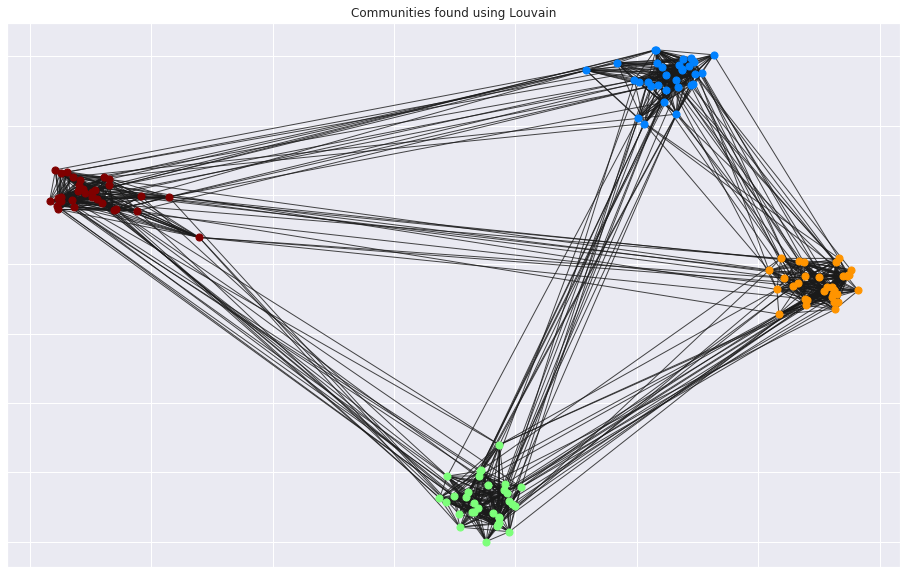

Normalize Mutual Info Scores for Louvain: [1.0, 1.0, 1.0, 1.0]


<Figure size 432x288 with 0 Axes>

Normalize Mutual Info Scores for Fast-Greedy: [1.0, 1.0, 1.0, 1.0]


<Figure size 432x288 with 0 Axes>

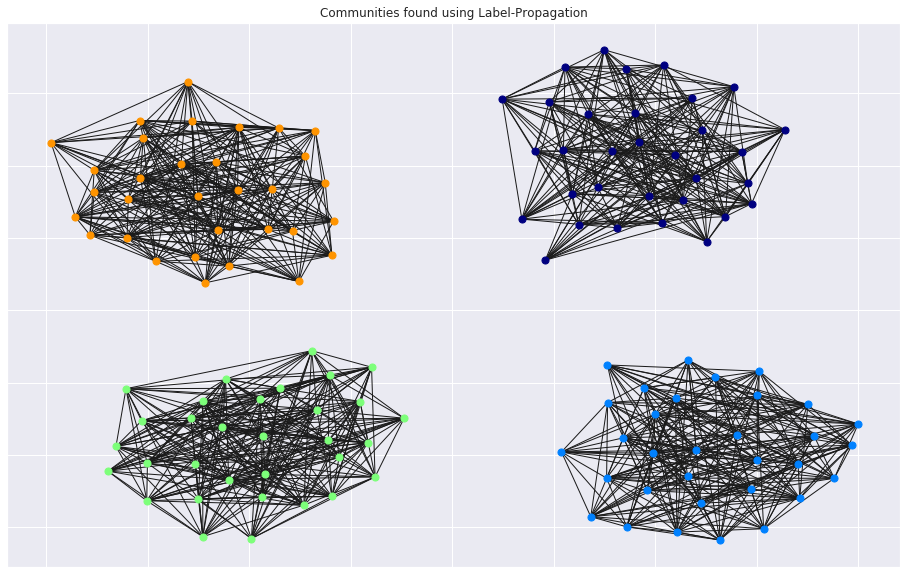

Normalize Mutual Info Scores for Label-Propagation: [1.0, 1.0, 1.0, 1.0]


Normalize Mutual Info Scores for Girvan Newman: [1.0, 1.0, 1.0, 1.0]


In [40]:
communities(G)

## 7.

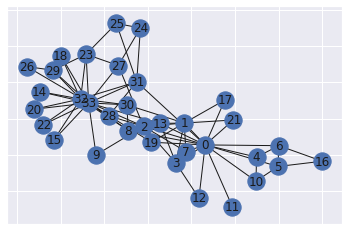

In [41]:
#Zachary karate club network
G=nx.karate_club_graph()
pos=nx.nx.fruchterman_reingold_layout(G)
nx.draw_networkx(G, pos=pos, node_color = 'b')
plt.show(True)

<Figure size 432x288 with 0 Axes>

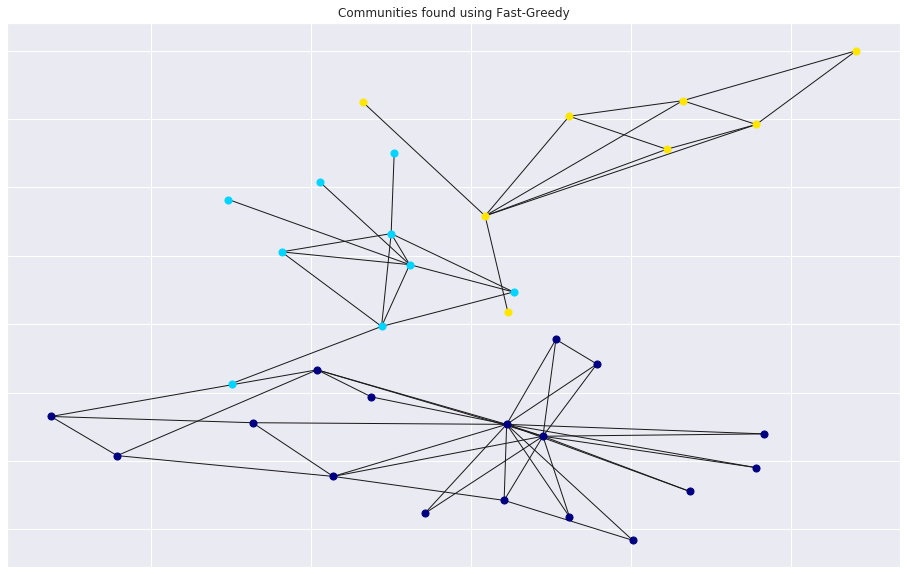

<Figure size 432x288 with 0 Axes>

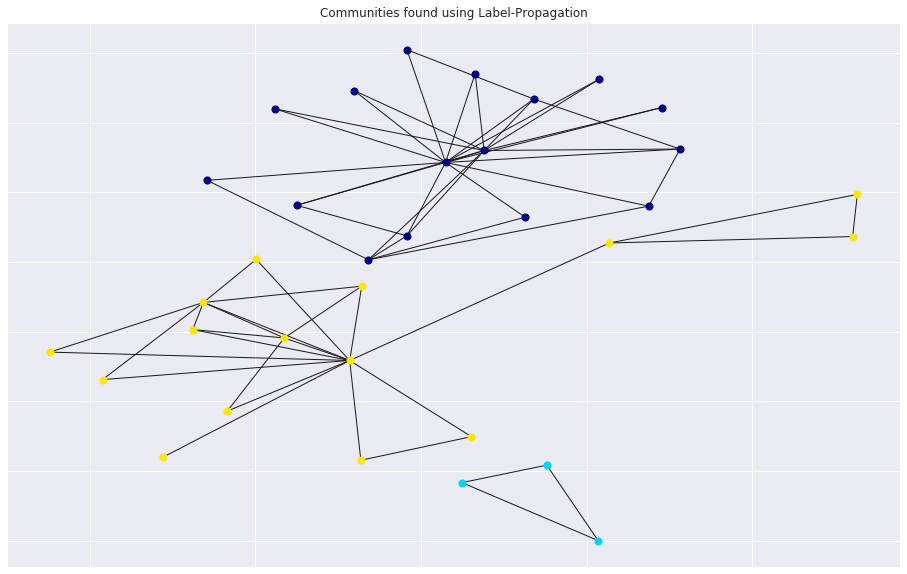

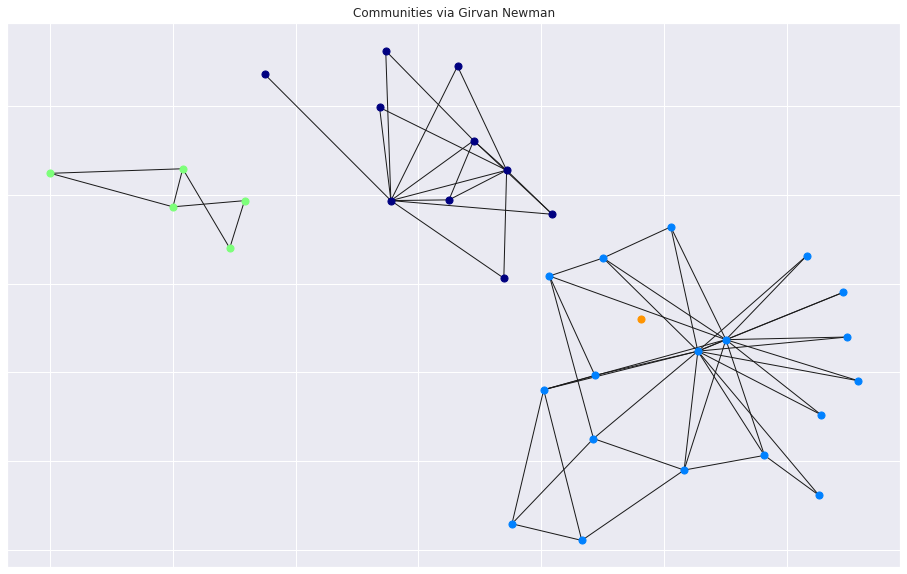

In [42]:
communities(G, mutual=False)

## 9.

In [43]:
import numpy as np
import networkx as nx
from scipy import sparse
from scipy.linalg import eig
from itertools import product

# Code Source: https://github.com/zhiyzuo/python-modularity-maximization/blob/master/modularity_maximization/utils.py

def get_modularity(network, community_dict):
    '''
    Calculate the modularity. Edge weights are ignored.
    Undirected:
    .. math:: Q = \frac{1}{2m}\sum_{i,j} \(A_ij - \frac{k_i k_j}{2m}\) * \detal_(c_i, c_j)
    Directed:
    .. math:: Q = \frac{1}{m}\sum_{i,j} \(A_ij - \frac{k_i^{in} k_j^{out}}{m}\) * \detal_{c_i, c_j}
    Parameters
    ----------
    network : nx.Graph or nx.DiGraph
        The network of interest
    community_dict : dict
        A dictionary to store the membership of each node
        Key is node and value is community index
    Returns
    -------
    float
        The modularity of `network` given `community_dict`
    '''

    Q = 0
    G = network.copy()
    nx.set_edge_attributes(G, {e:1 for e in G.edges}, 'weight')
    A = nx.to_scipy_sparse_matrix(G).astype(float)

    if type(G) == nx.Graph:
        # for undirected graphs, in and out treated as the same thing
        out_degree = in_degree = dict(nx.degree(G))
        M = 2.*(G.number_of_edges())
        #print("Calculating modularity for undirected graph")
    elif type(G) == nx.DiGraph:
        in_degree = dict(G.in_degree())
        out_degree = dict(G.out_degree())
        M = 1.*G.number_of_edges()
        #print("Calculating modularity for directed graph")
    else:
        print('Invalid graph type')
        raise TypeError

    nodes = list(G)
    Q = np.sum([A[i,j] - in_degree[nodes[i]]*\
                         out_degree[nodes[j]]/M\
                 for i, j in product(range(len(nodes)),\
                                     range(len(nodes))) \
                if community_dict[nodes[i]] == community_dict[nodes[j]]])
    return Q / M

In [44]:
## Reading the nets
eroad_net = nx.read_edgelist(path='nets/subelj_euroroad/out.subelj_euroroad_euroroad', comments='%')
celegan_net = nx.read_gml(path='nets/celegansneural/celegansneural.gml',)
airport_net = nx.read_weighted_edgelist(path='nets/USairport500.dl.txt', comments='%') 
human_proteins_net = nx.read_edgelist(
    path='nets/download.tsv.maayan-vidal/maayan-vidal/out.maayan-vidal', comments='%')

nets = {'E-road' : process_net(eroad_net),
        'Airport' : process_net(airport_net), 
        'Celegan' : process_net(celegan_net),
        'Human_Protein' : process_net(human_proteins_net)}

for _, net in nets.items():
    print(len(net.nodes()))

1039
500
297
2783


**Only using the two smallest networks because of computational issues**

In [45]:
import numpy as np
import pandas as pd
from networkx.algorithms.community import quality
#	(i)	Fastgreedy,		(ii)	Label	propagation,	(iii)	Givan	Newman,	(iv) Louvain

table = {'N': [], 'Average_Degree': [], 'Assortativity': [], 'Modularity_FastGreedy': [
], 'Modularity_LabelPropagation': [], 'Modularity_Girvan': [], 'Modularity_Louvain': []}


def average_degree(G):

    degrees = np.array([val for val in dict(nx.degree(G)).values()])

    return degrees.mean()


for name in ['Airport', 'Celegan']:
    table['N'].append(len(nets[name].nodes()))
    table['Average_Degree'].append(average_degree(nets[name]))
    table['Assortativity'].append(nx.assortativity.degree_assortativity_coefficient(nets[name]))

    louvain_partition = community_louvain.best_partition(nets[name])
    table['Modularity_Louvain'].append(get_modularity(nets[name], louvain_partition))
    fast_partition = nx.algorithms.community.greedy_modularity_communities(nets[name])
    table['Modularity_FastGreedy'].append(quality.modularity(nets[name], fast_partition))

    label_partition = nx.algorithms.community.label_propagation_communities(nets[name])
    table['Modularity_LabelPropagation'].append(quality.modularity(nets[name], label_partition))
    
    try:
        
        girvan_partition = nx.algorithms.community.centrality.girvan_newman(nets[name])
        table['Modularity_Girvan'].append(
            quality.modularity(nets[name], girvan_partition))
    except:
        table['Modularity_Girvan'].append(0)

table_df = pd.DataFrame.from_dict(table)

In [46]:
table_df

N  Average_Degree  Assortativity  Modularity_FastGreedy  \
0  500       11.920000      -0.267863          -2.592707e-17   
1  297       14.464646      -0.163199           3.692011e-01   

   Modularity_LabelPropagation  Modularity_Girvan  Modularity_Louvain  
0                 8.466766e-03                  0            0.339950  
1                -8.576769e-18                  0            0.379108

## 10.
 – Consider	the	following	networks:  
 
a)	E-road	network	(http://konect.cc/networks/subelj_euroroad),

b)	C.	elegans	neural	network	

(http://www-personal.umich.edu/~mejn/netdata/celegansneural.zip)

c)	US	airport	network	(http://toreopsahl.com/datasets/#usairports)

For each network above find it's communities using the previous discussed methods.

E-road communities

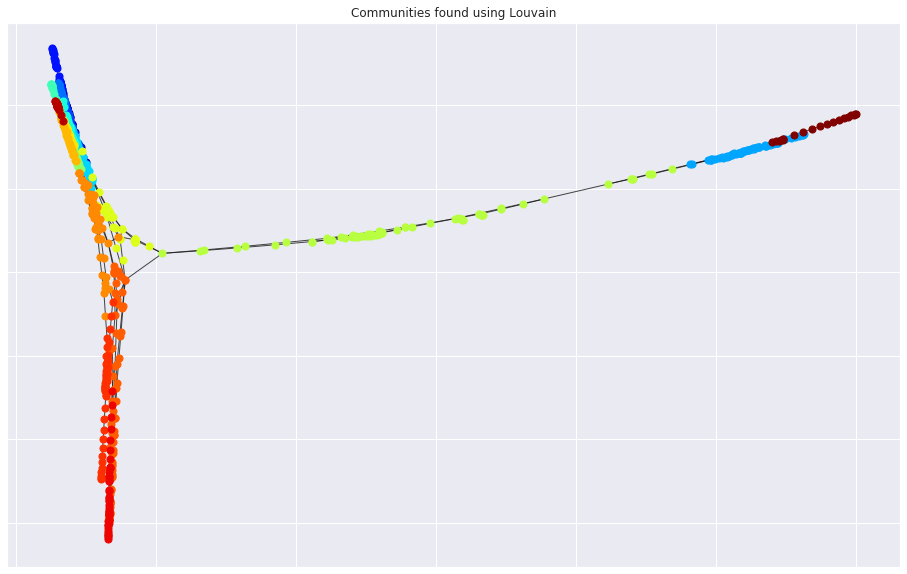

<Figure size 432x288 with 0 Axes>

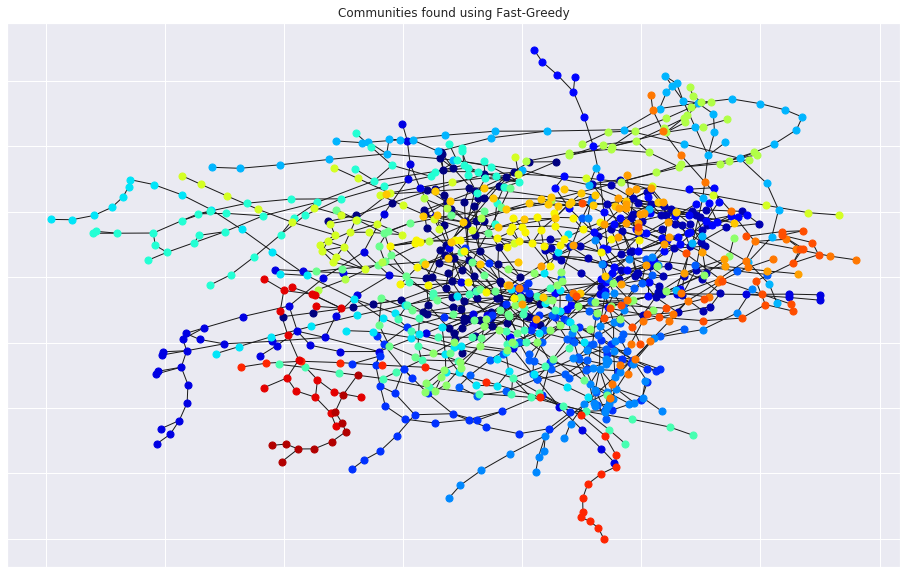

<Figure size 432x288 with 0 Axes>

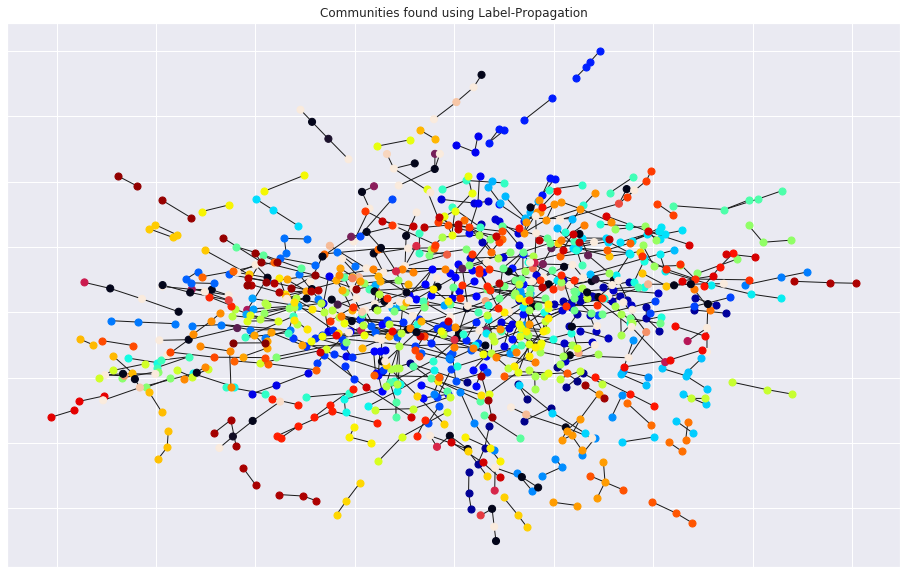

In [47]:
communities(nets['E-road'], mutual=False)

C.elegans communities

<Figure size 432x288 with 0 Axes>

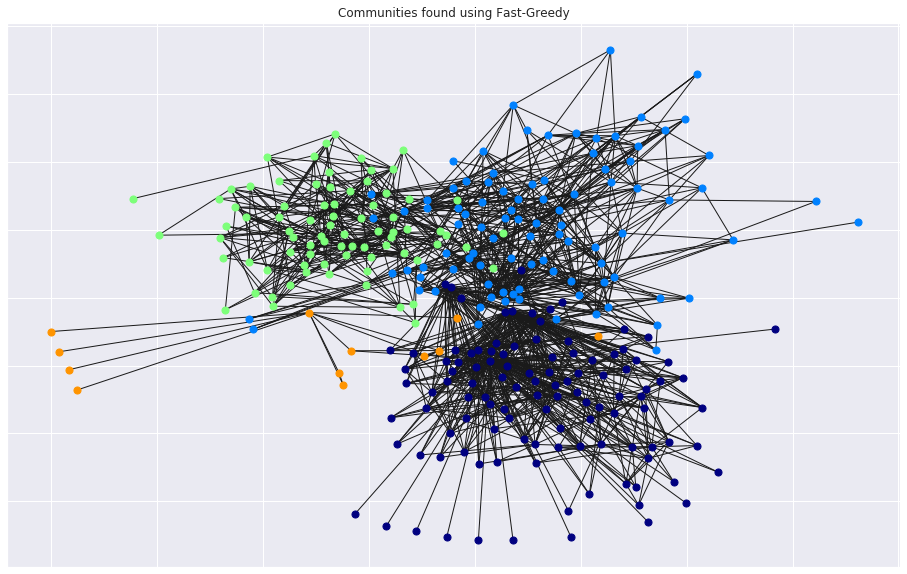

<Figure size 432x288 with 0 Axes>

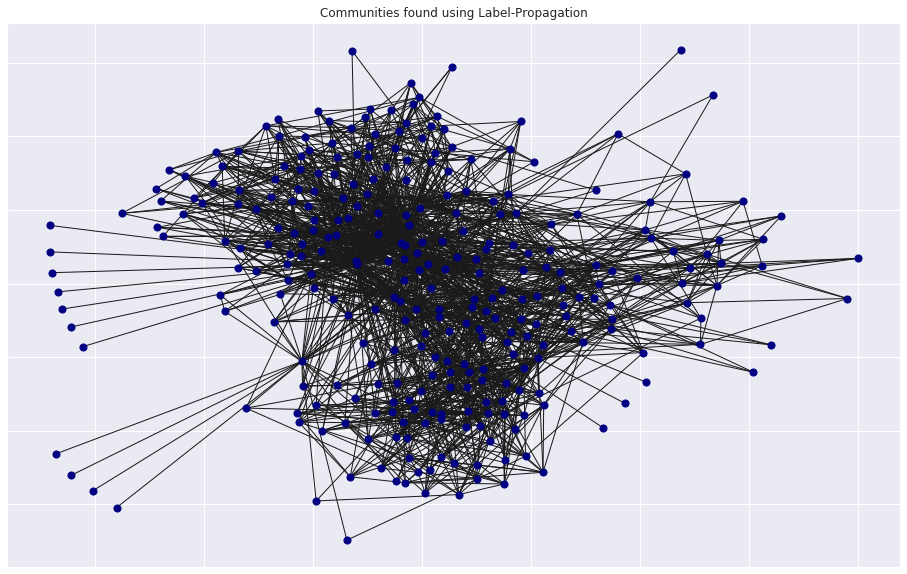

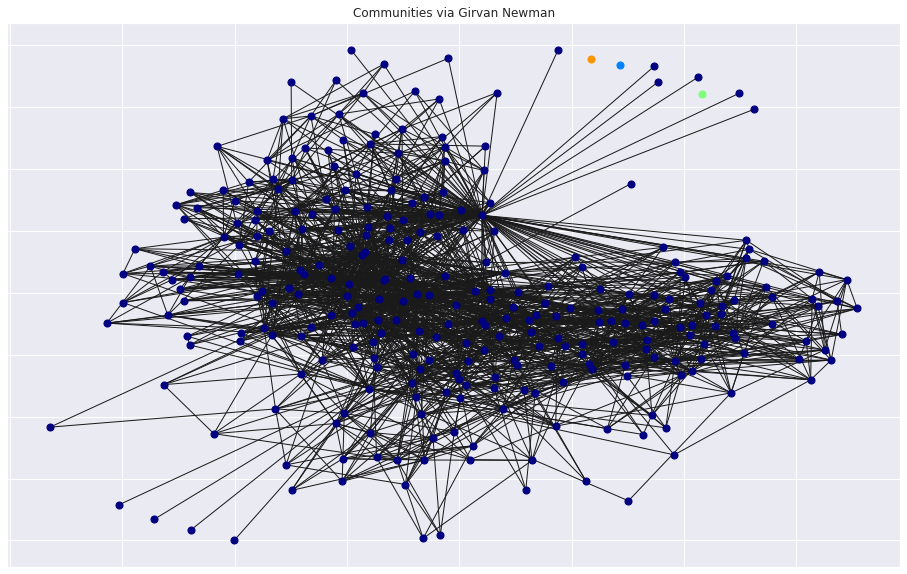

In [48]:
communities(nets['Celegan'], mutual=False)

Airport communities

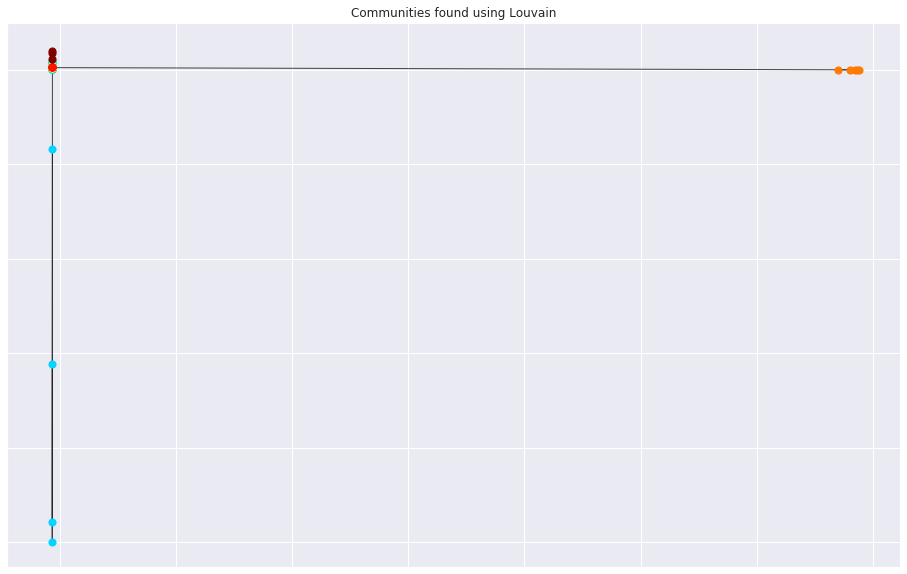

<Figure size 432x288 with 0 Axes>

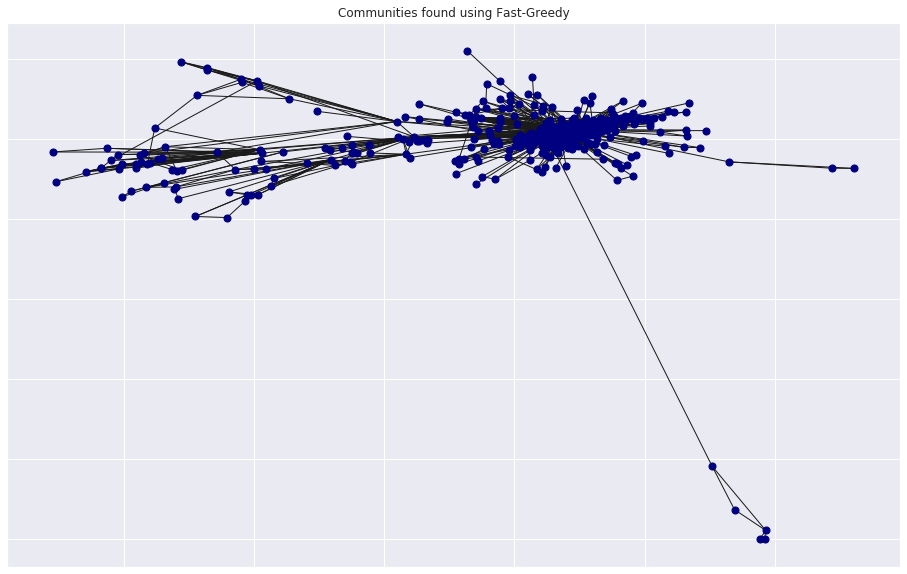

<Figure size 432x288 with 0 Axes>

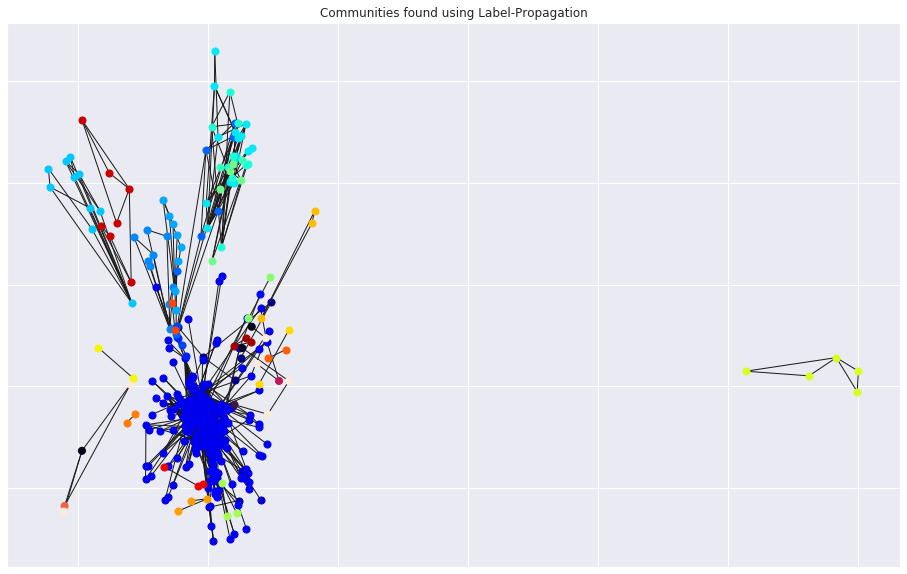

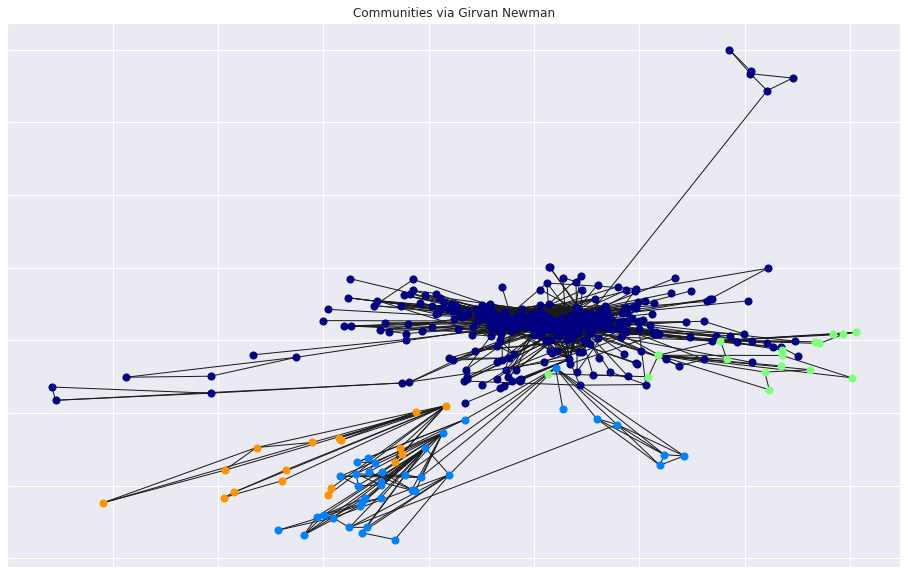

In [49]:
communities(nets['Airport'], mutual=False)